In [ ]:
#from textblob import TextBlob
import pandas as pd
import re, string
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install top2vec
!pip install top2vec[sentence_transformers]
!pip install top2vec[sentence_encoders]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install pyLDAvis

In [ ]:
# # libraries for visualization
# import pyLDAvis
# import pyLDAvis.gensim
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
review_data = pd.read_csv('/content/drive/MyDrive/Amazon reviews/Reviews.csv')

#**Data pre-processing**

In [ ]:
review_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
print('\033[1m Number of Unique users:', len(review_data.groupby('UserId')))

 Number of Unique users: 256059


In [ ]:
#print('Number of unique reviews:', review_data['Text'].nunique())
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
#remove reduntant features
review_data = review_data.drop(columns = ['ProductId', 'UserId', 'ProfileName', 'Id', 'Time', 'Summary']) 
review_data

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text
0,1,1,5,I have bought several of the Vitality canned d...
1,0,0,1,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,This is a confection that has been around a fe...
3,3,3,2,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy at a great price. There was a wid...
...,...,...,...,...
568449,0,0,5,Great for sesame chicken..this is a good if no...
568450,0,0,2,I'm disappointed with the flavor. The chocolat...
568451,2,2,5,"These stars are small, so you can give 10-15 o..."
568452,1,1,5,These are the BEST treats for training and rew...


In [ ]:
#this function will remove special characters, digits and words having characters less than or equal to three
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [ ]:
review_data.dropna(axis = 0, how ='any',inplace=True) 
review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print('-------------------------')
# max_review_data_sentence_length  = review_data['Num_words_text'].max()

mask = (review_data['Num_words_text'] < 30) & (review_data['Num_words_text'] >=5)
df_short_reviews = review_data[mask]

#sample only 5000 instances for each value of score, in total 5*5000 instances
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=5000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64
-------------------------
No of Short reviews
265717


In [ ]:
print(review_data['Text'][0])

have bought several vitality canned food products have found them good quality product looks more like stew than processed meat smells better labrador finicky appreciates this product better than most


In [ ]:
df_sampled

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Text,Num_words_text
0,0,0,1,love happybaby products twins like most them u...,17
1,2,2,1,these were very poor quality truffles with abs...,19
2,1,1,1,weak unpleasant flavor wont ordering again dis...,13
3,0,0,1,gave first jumbone days since then been super ...,19
4,1,1,1,high hopes that could tollerate this calorie p...,20
...,...,...,...,...,...
24995,0,0,5,this great only health taste very light great ...,10
24996,0,0,5,really loves these treats very picky years pre...,20
24997,0,0,5,love these things makes feel better eating pre...,24
24998,0,0,5,favorite hard candy kinda crazy number them do...,11


$\Large\text{As can be seen from the above result that special charcters, stopwords, digits are removed from the text.}$

In [ ]:
!pip uninstall numba

Found existing installation: numba 0.57.0
Uninstalling numba-0.57.0:
  Would remove:
    /usr/local/bin/numba
    /usr/local/lib/python3.10/dist-packages/numba-0.57.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numba/*
Proceed (Y/n)? Y
  Successfully uninstalled numba-0.57.0


In [ ]:
!pip install -U numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numba-0.57.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)


In [ ]:
from top2vec import Top2Vec

In [ ]:
model = Top2Vec(df_sampled.Text.values, embedding_model='universal-sentence-encoder')

2023-05-18 12:57:49,322 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-05-18 12:57:57,412 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2023-05-18 12:58:23,517 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-05-18 12:58:32,181 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-05-18 12:59:41,192 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-05-18 12:59:45,170 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
model.get_num_topics()

119

In [ ]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [ ]:
print(topic_sizes)

[2312 1340 1004  831  590  563  494  480  472  467  461  440  414  389
  385  376  362  359  352  347  328  327  324  318  311  293  290  283
  277  248  245  237  225  215  209  204  202  199  199  195  192  191
  191  180  178  176  170  163  160  156  155  154  151  150  148  148
  146  141  139  136  136  134  131  127  125  124  123  121  120  111
  105  102   98   95   91   89   88   88   85   84   84   79   75   74
   71   69   69   67   66   65   64   63   63   60   59   59   57   56
   55   50   49   48   48   47   46   46   44   44   40   40   39   39
   38   37   27   26   25   22   21]


In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(36)

In [ ]:
print(word_scores)

[[0.5990692  0.5781833  0.56120646 ... 0.20364046 0.20314644 0.20299271]
 [0.41653493 0.36873966 0.3283587  ... 0.18608995 0.18602625 0.1855675 ]
 [0.35147583 0.34492636 0.3373327  ... 0.14112607 0.14093614 0.1396148 ]
 ...
 [0.5699081  0.34729394 0.34604478 ... 0.21728243 0.21670616 0.21632552]
 [0.43438593 0.4317302  0.4226055  ... 0.25307965 0.25214756 0.2519303 ]
 [0.5022701  0.49952632 0.49235305 ... 0.24253088 0.24203481 0.23670052]]


In [ ]:
print(topic_words)

[['coffees' 'keurig' 'coffee' ... 'cream' 'beer' 'creamy']
 ['treats' 'greenies' 'chewy' ... 'eaten' 'cookies' 'dried']
 ['amazon' 'walmart' 'amazoncom' ... 'prime' 'packaging' 'newmans']
 ...
 ['coconut' 'flavoring' 'stevia' ... 'keurig' 'granola' 'newmans']
 ['fruit' 'banana' 'fruits' ... 'pretzels' 'aftertaste' 'tastes']
 ['flavors' 'flavour' 'flavored' ... 'coconut' 'fruits' 'tart']]


In [ ]:
print(topic_words[0])

['coffees' 'keurig' 'coffee' 'espresso' 'cappuccino' 'decaf' 'starbucks'
 'latte' 'brewed' 'mocha' 'creamer' 'caffeine' 'hazelnut' 'brew' 'chai'
 'flavoring' 'brewing' 'iced' 'splenda' 'brewer' 'aroma' 'sweetener'
 'stevia' 'kettle' 'aftertaste' 'flavorful' 'teas' 'bitterness' 'caramel'
 'blends' 'flavored' 'kcups' 'kona' 'sugarfree' 'bean' 'sweetened' 'beans'
 'flavors' 'bitter' 'vanilla' 'donut' 'kcup' 'tasting' 'drinker' 'cocoa'
 'flavor' 'licorice' 'cream' 'beer' 'creamy']


In [ ]:
print(topic_words[1])

['treats' 'greenies' 'chewy' 'puppy' 'dogs' 'chews' 'chewing' 'jerky'
 'wellness' 'crumbs' 'crunchy' 'chewed' 'pretzels' 'candies' 'edible'
 'peanut' 'tasted' 'oatmeal' 'yummy' 'raisins' 'peanuts' 'feed' 'tasty'
 'taste' 'delicious' 'chew' 'treat' 'newmans' 'sugarfree' 'gummy' 'cookie'
 'chocolates' 'pork' 'tastes' 'noodles' 'food' 'chocolate' 'beef'
 'feeding' 'training' 'licorice' 'kona' 'processed' 'bones' 'noodle'
 'yogurt' 'cheddar' 'eaten' 'cookies' 'dried']


In [ ]:
print(topic_words[15])

['chips' 'chip' 'pretzels' 'flavour' 'snacks' 'crispy' 'snack' 'popcorn'
 'crunchy' 'salty' 'crisp' 'cheddar' 'flavors' 'yummy' 'flavored' 'salt'
 'flavor' 'baked' 'seasoning' 'potato' 'delicious' 'flavorful' 'spicy'
 'flavoring' 'craving' 'tasty' 'chewy' 'packets' 'almonds' 'candies'
 'jerky' 'wasabi' 'kernels' 'cookies' 'tasted' 'crumbs' 'peanuts' 'packet'
 'gummy' 'sour' 'treats' 'stale' 'raisins' 'aftertaste' 'taste'
 'raspberry' 'tastes' 'noodles' 'cheese' 'vinegar']


In [ ]:
topic_nums

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["candy"], num_topics=19)

In [ ]:
topic_nums

array([ 19,  95,  82,   4, 107,  27,   5,   9,   6, 109,  88,  63,  68,
        76,  72,  41,  34,  15,  50])

In [ ]:
topic_scores

array([0.58103011, 0.42735381, 0.39224231, 0.33332822, 0.30459047,
       0.26944669, 0.26583293, 0.26570691, 0.25780413, 0.24793352,
       0.24682171, 0.24598866, 0.244071  , 0.23597833, 0.22924002,
       0.22199454, 0.22157077, 0.21876171, 0.217047  ])

topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.

word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.

topic_scores: For each topic the cosine similarity to the search keywords will be returned.

topic_nums: The unique index of every topic will be returned.

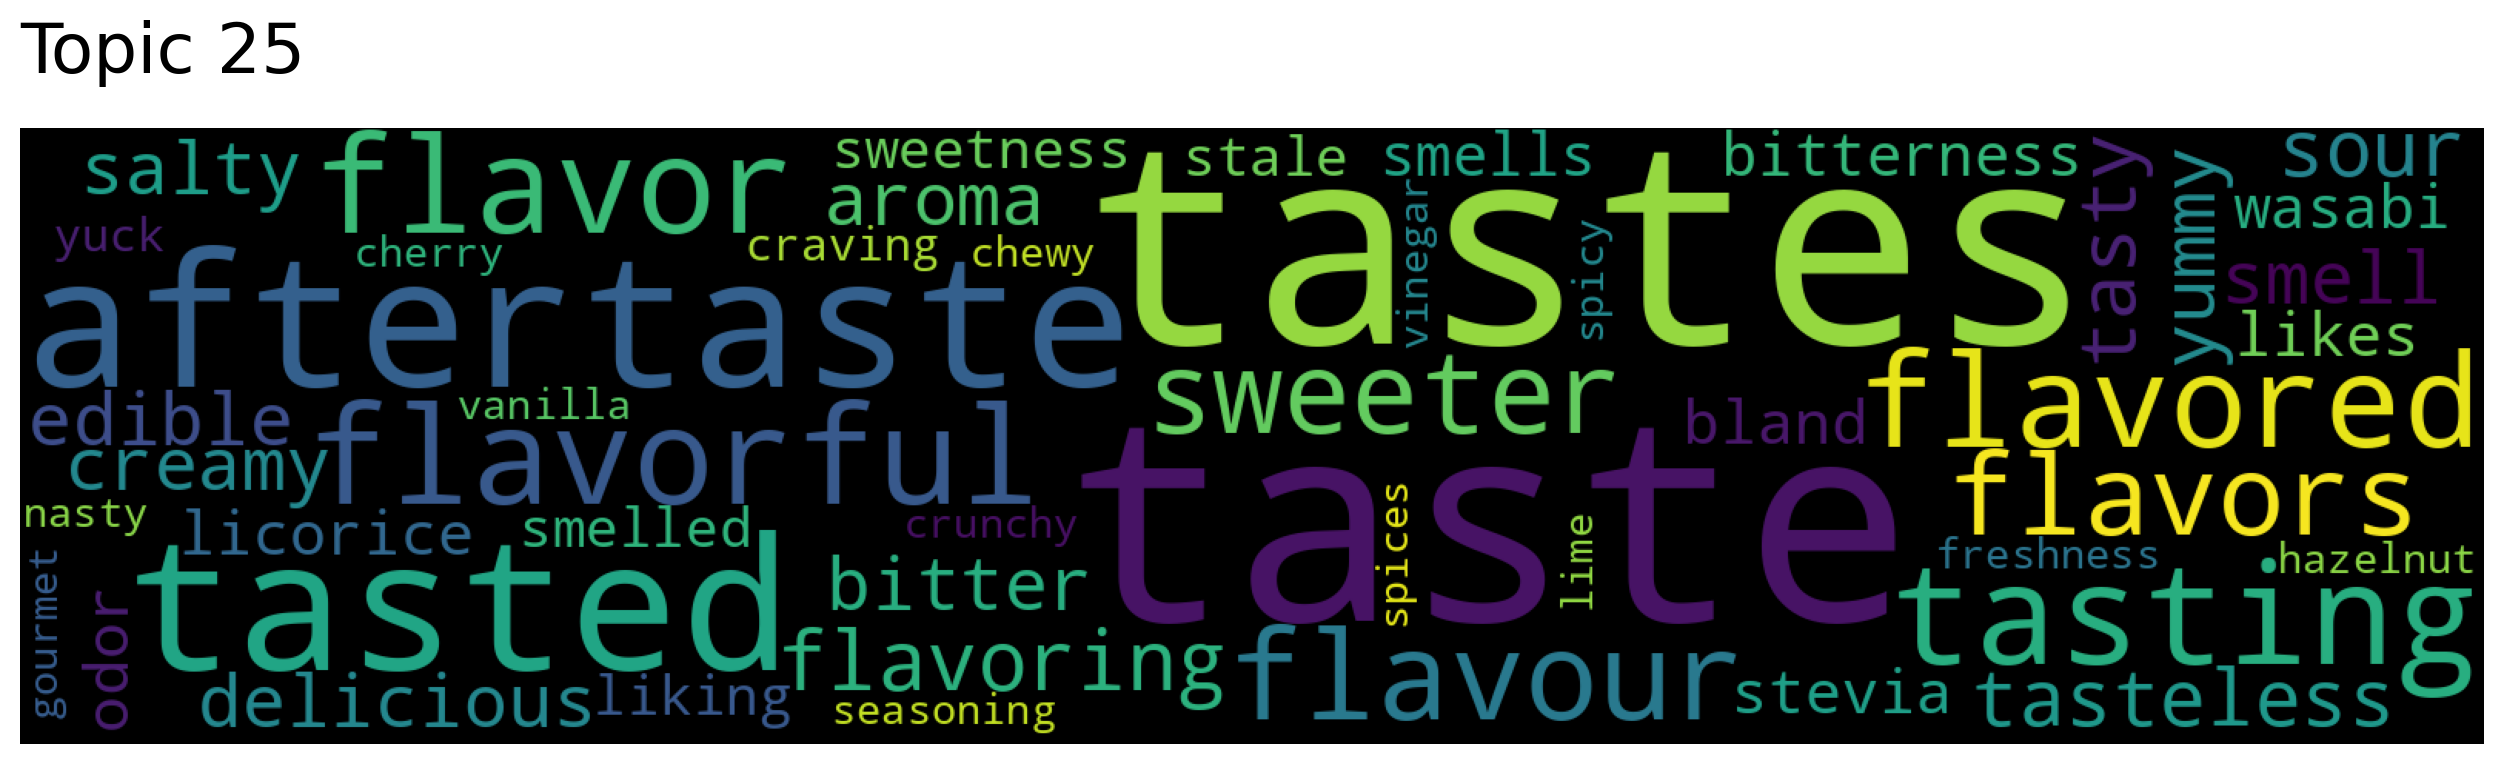

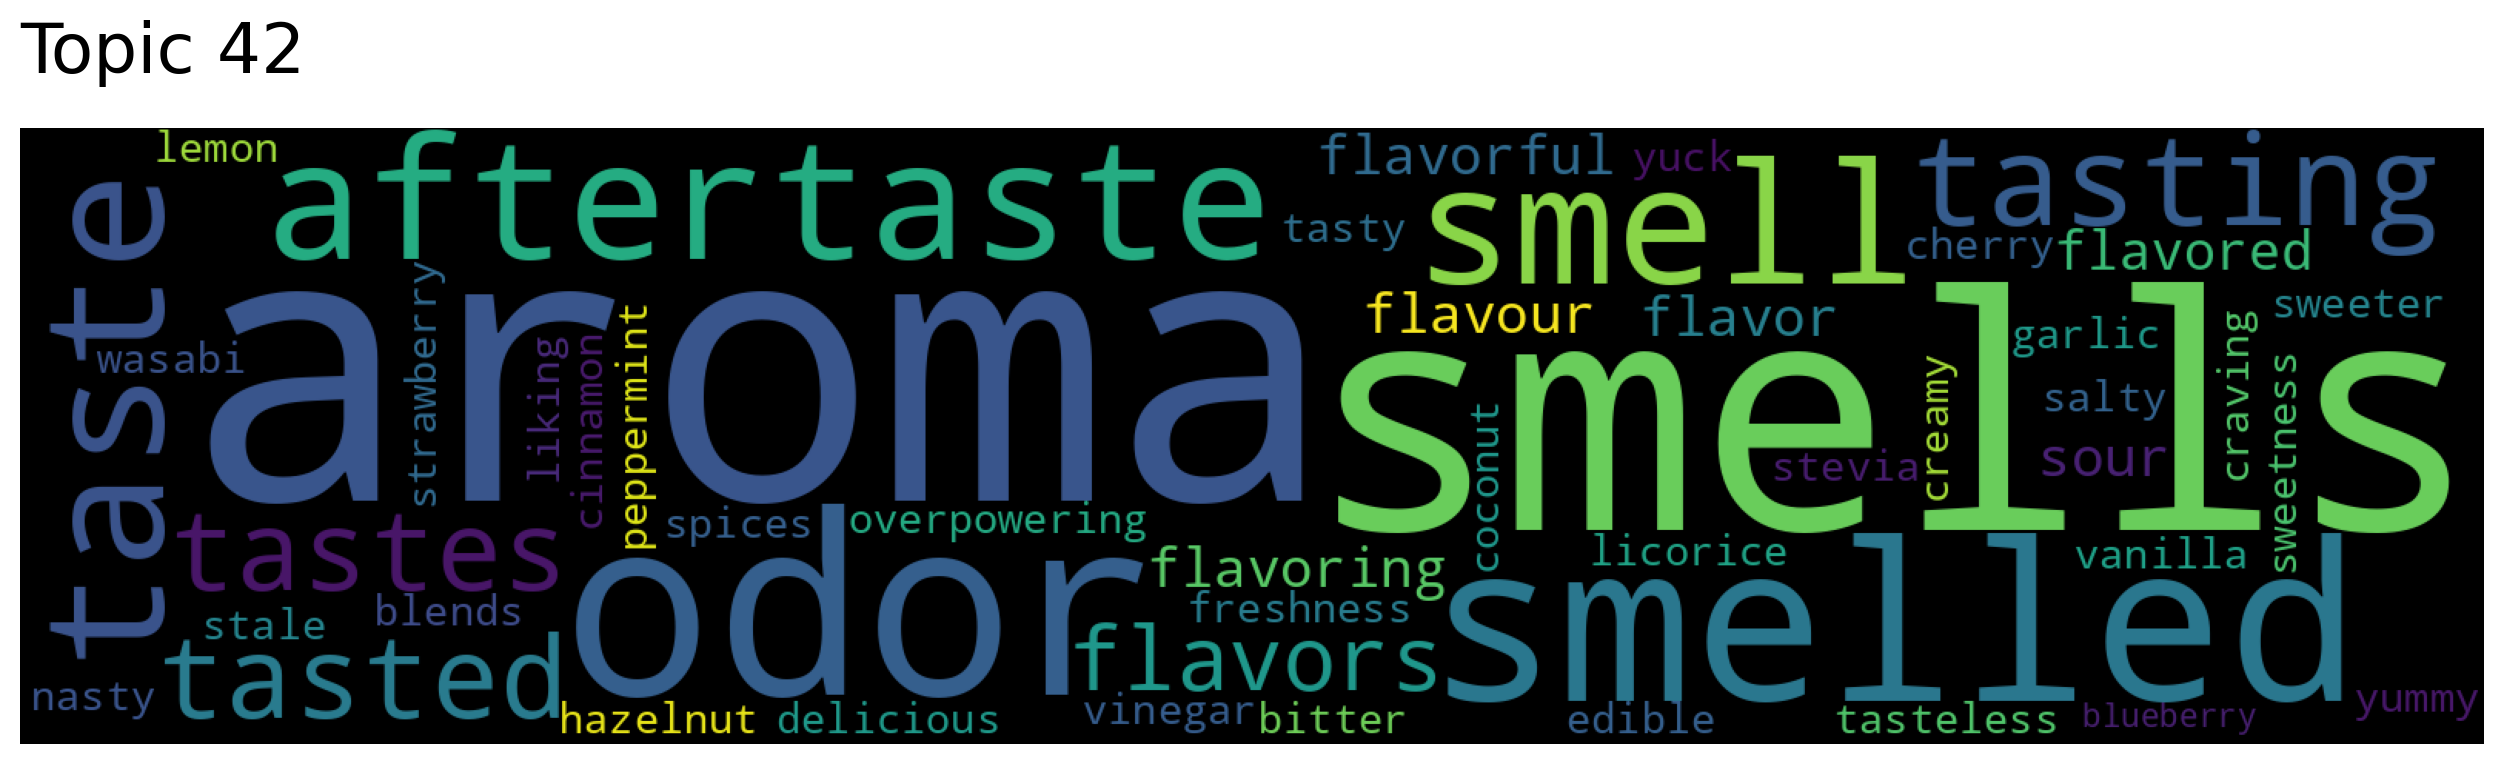

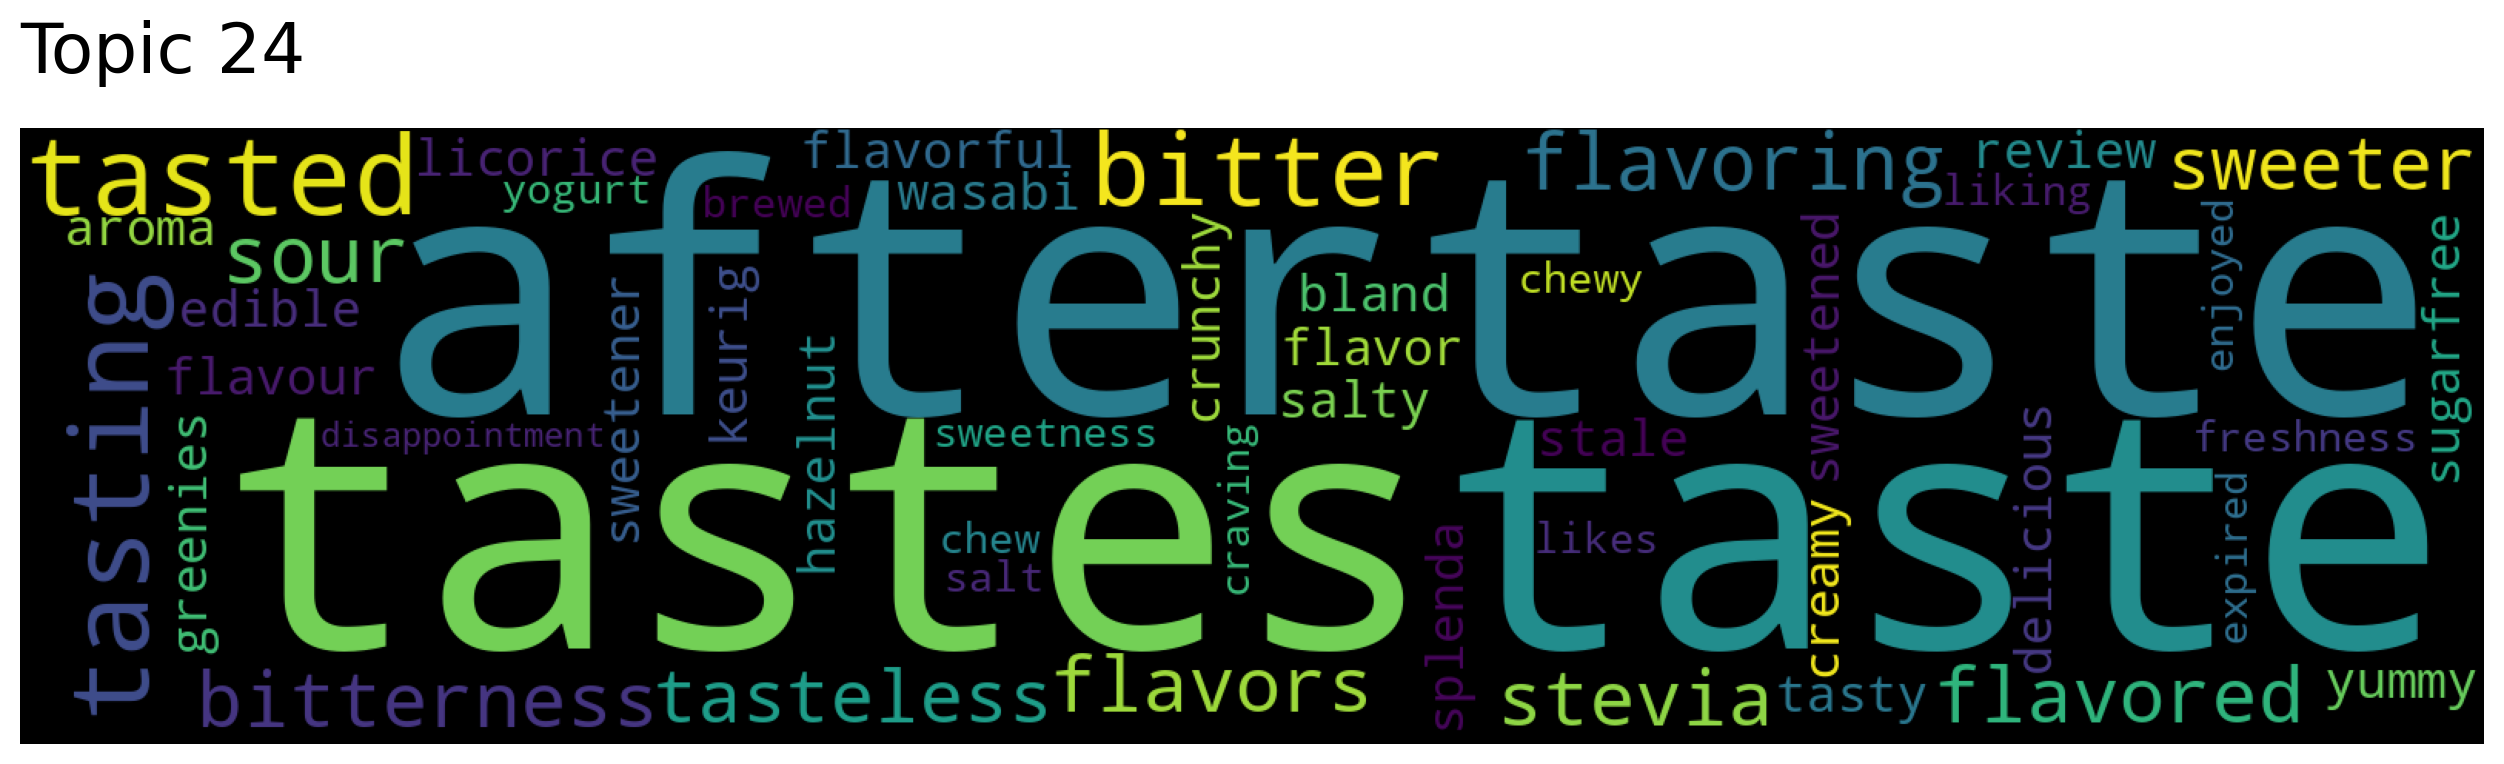

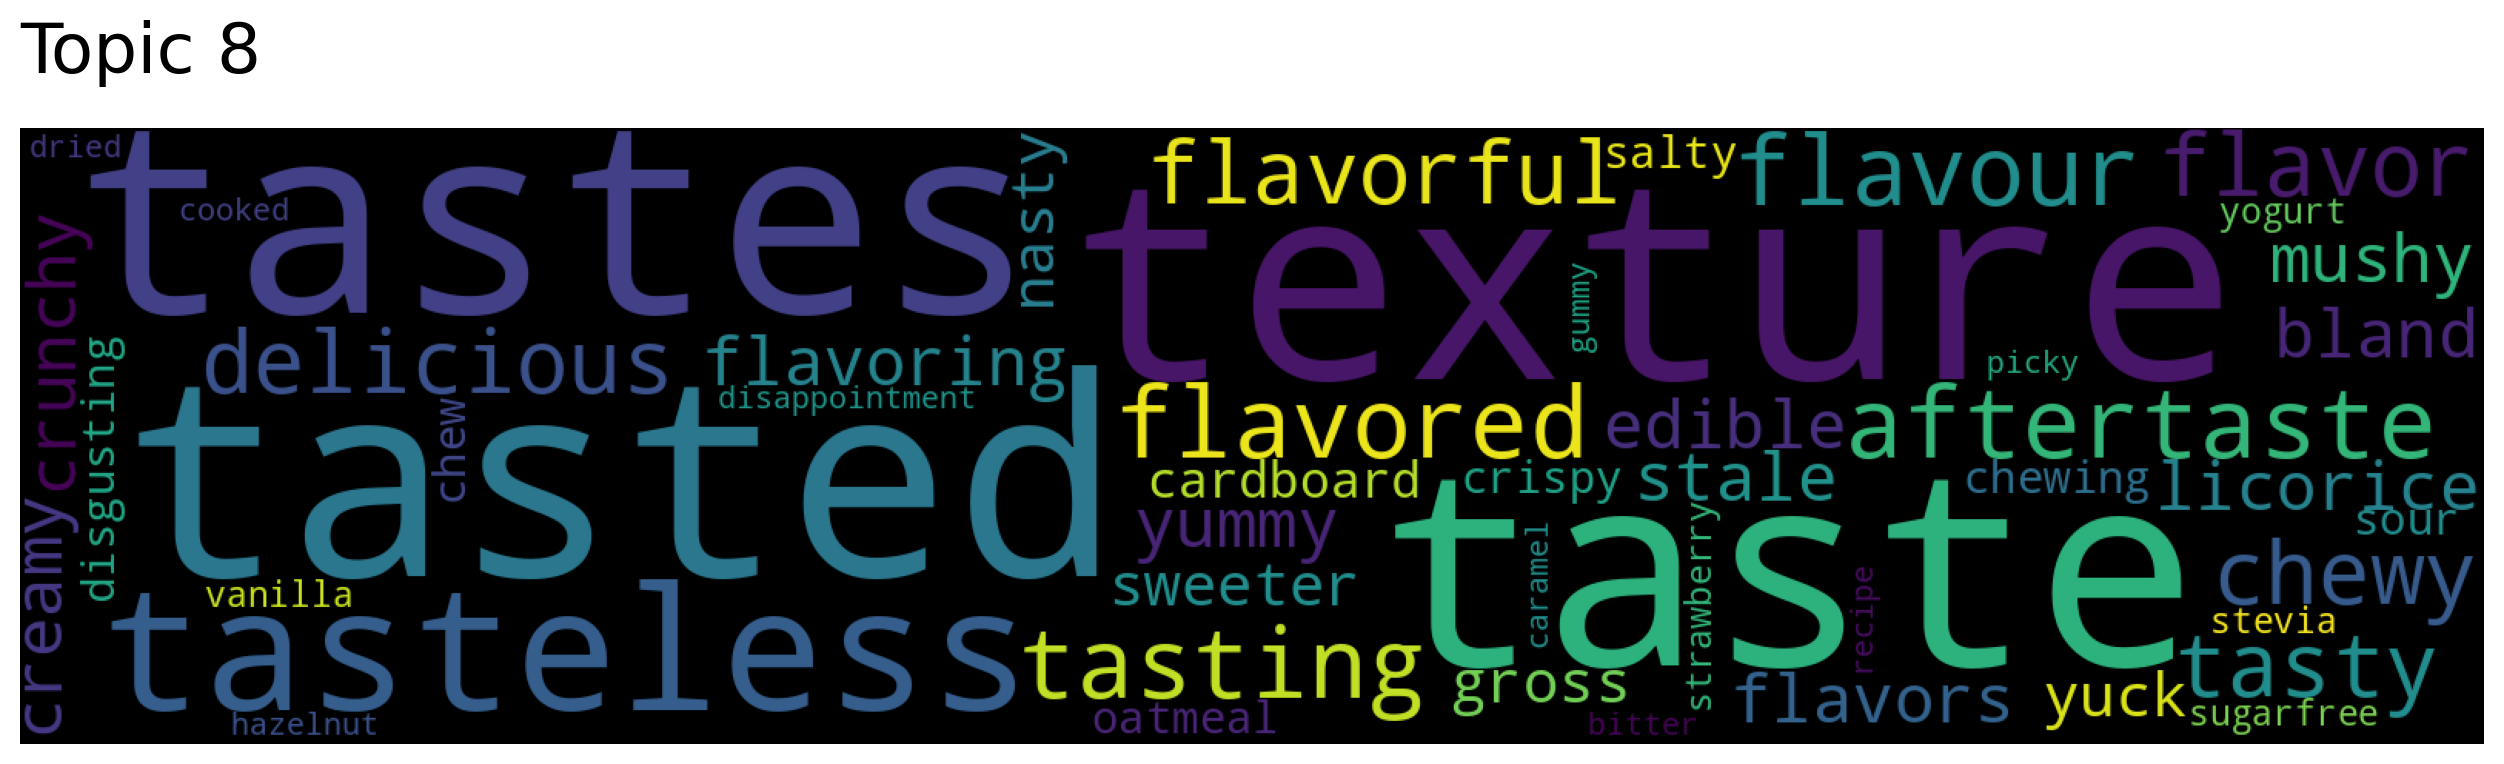

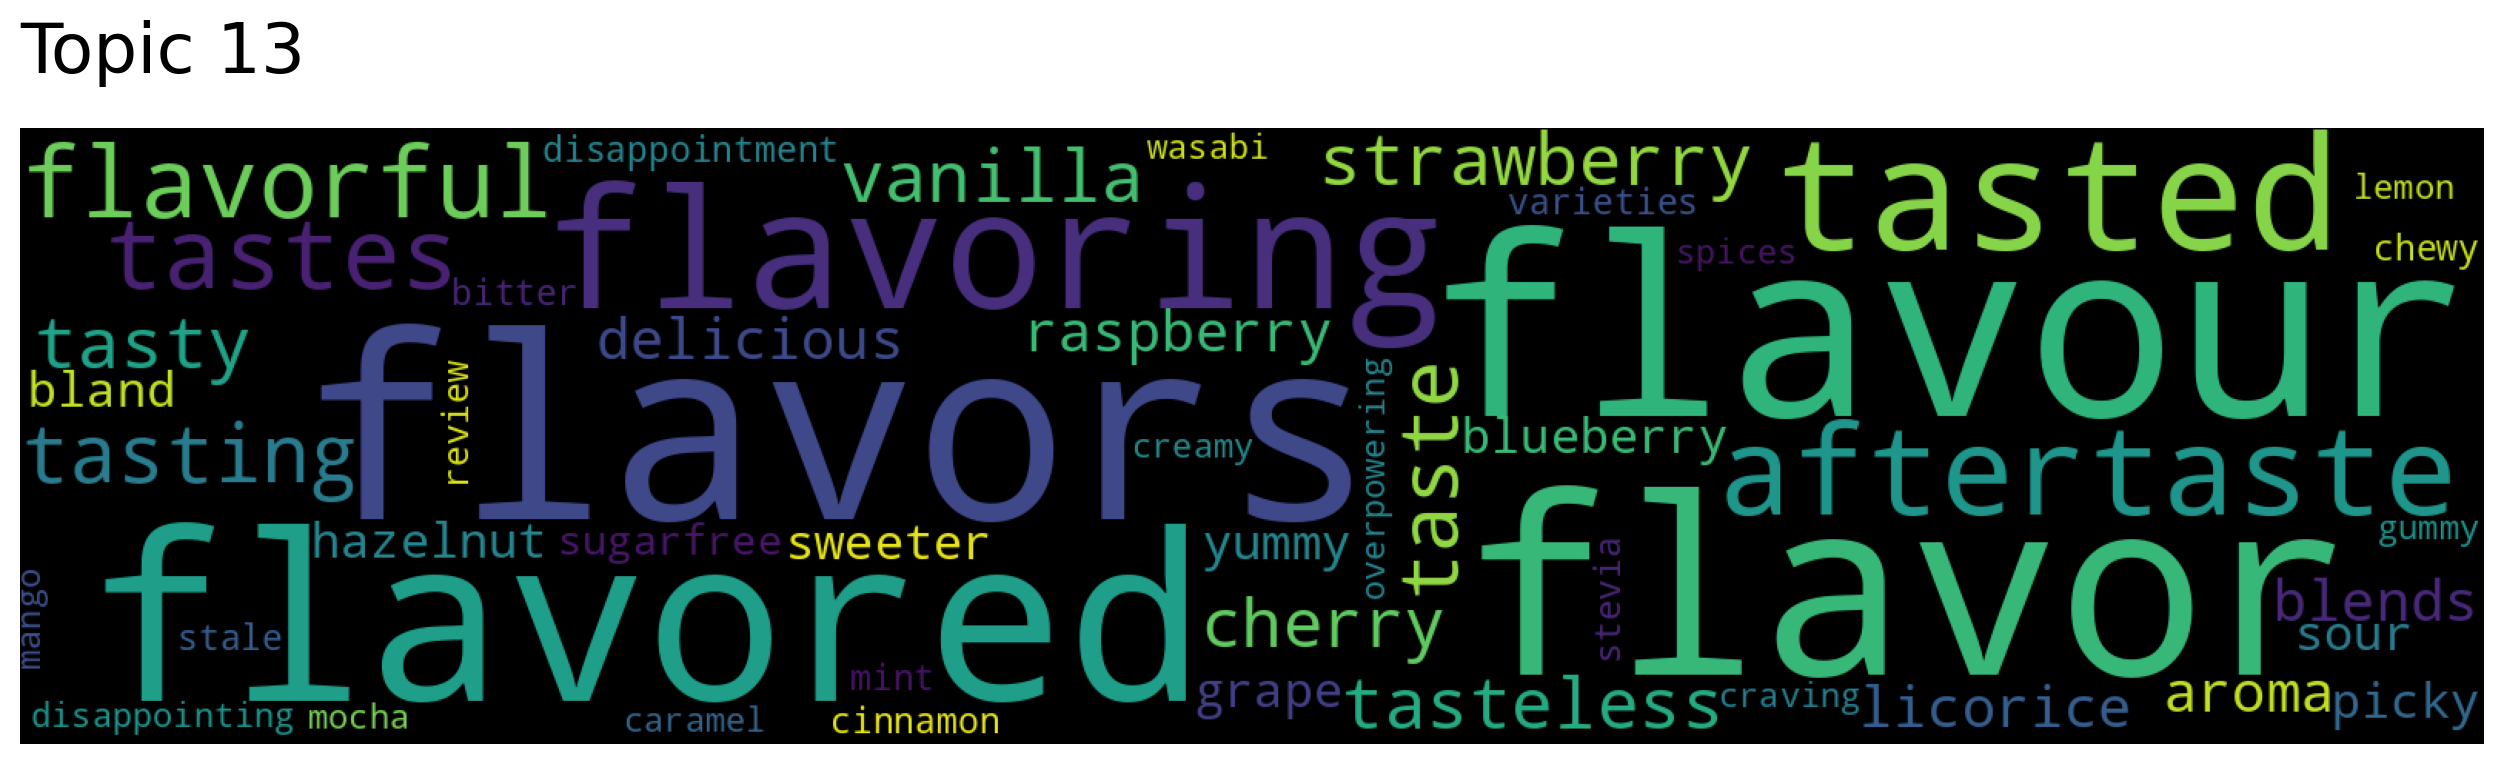

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["taste"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=17, num_docs=15)

In [ ]:
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 21511, Score: 0.8107522130012512
-----------
great service fast shipment overall exactly what asked very pleased will defiantly purchase again
-----------

Document: 20115, Score: 0.7799249887466431
-----------
reveived item fast exactly what ordered excellent shape with safe shipping will came back shop here again thanks
-----------

Document: 23871, Score: 0.7603906989097595
-----------
great product good shipping time seller responds quickly bends over backwards satisfy
-----------

Document: 22379, Score: 0.7587333917617798
-----------
ordered from this dealer past plan order again soon excellent product excellent service very very pleased
-----------

Document: 23541, Score: 0.7392082810401917
-----------
these wonderful product description says have ordered previously will order again makes great gift shipped promptly
-----------

Document: 23661, Score: 0.7389669418334961
-----------
recieved product time excellent shape tastes good meets expectations thanks excellent 

documents: The documents in a list, the most similar are first.

doc_scores: Semantic similarity of document to topic. The cosine similarity of the document and topic vector.

doc_ids: Unique ids of documents. If ids were not given, the index of document in the original corpus

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["delicious", "food"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

In [ ]:
words, word_scores = model.similar_words(keywords=["chocolate"], keywords_neg=[], num_words=30)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["nuts"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["FOOD"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["color"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)